# Basics

With a `GameManager` object we can manipulate the game state as we desire.

In [1]:
from core.game import GameManager

In [2]:
gm = GameManager()

We can build our own `board` and `state` or simply start with an existing one. 

In this case we use a scenario where we have 2 red tanks and 2 blue tanks.

In [3]:
from core.scenarios import buildScenario

In [4]:
board, state = buildScenario('Test2v2')

From the state, we get our figures.

In [5]:
from core.const import RED, BLUE

In [6]:
r1, b2 = state.getFigures(RED)
b1, b2 = state.getFigures(BLUE)

As an example, we want to attack `b1` with `r1` using `r1`'s cannon (`CA`):

In [7]:
try:
    atk = gm.actionAttack(board, state, r1, b2, r1.weapons['CA'])
except ValueError as e:
    print(e)

Cannon cannot hit Tank4(12, 12) from (2, 2): no LOS on target


...and we cannot do that since we don't have LOS on target. We need to first move `r1`to have a clean LOS on target.

Let's try to move `r1` around. Its current position is:

In [8]:
r1.position

(2, -3, 1)

A triple means that it's current position is expressed in `cube-space`, we want coordinates in `grid-space` since it is much more natural for us. We just need to convert to `tuple`:

In [9]:
r1.position.tuple()

(2, 2)

The game works in cube-space so any position need to be expressed in `Cube`. Fortunately we can use the coordinates utility classes to to convert from `grid-space` (`Hex`) to `cube-space` (`Cube`).

In [10]:
from core.utils.coordinates import Hex

In [11]:
dst = Hex(4,4).cube()
m = gm.actionMove(board, state, r1, destination=dst)
m

red  : Tank1     : Move to (4, 4)

Object `m` is our movement action from `(2,2)` (current position of `r1`) to `(4,4)`.

We can now generate a new state where the tank `r1` changed its position.

In [12]:
new_state, outcome = gm.activate(board, state, m)

Note how `new_state` is not the same as previous `state`.

In [13]:
new_state == state

False

We can check by looking at the images of the states:

In [14]:
from utils.images import drawState

We can globally change the size of the output images (I suggest to use multiples of 6 to avoid artifacts).

In [15]:
import utils.images
utils.images.SIZE = 24

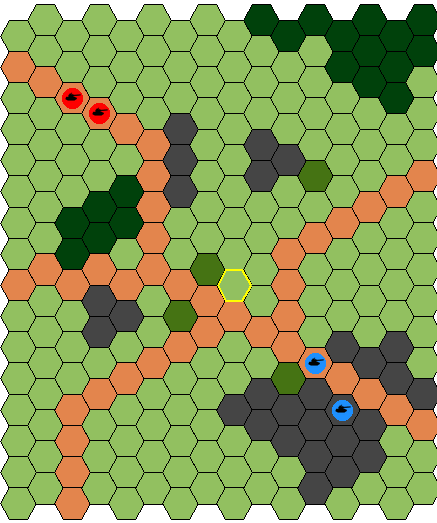

In [16]:
drawState(board, state)

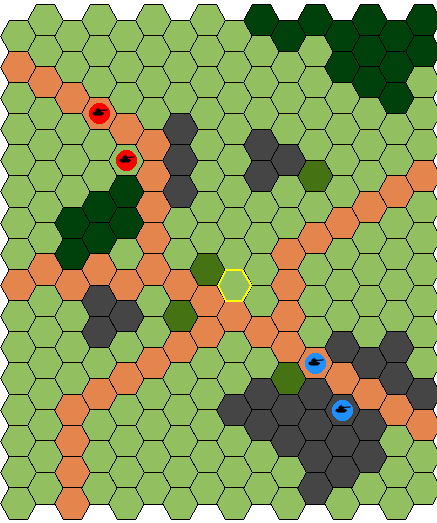

In [17]:
 drawState(board, new_state)

Or we can directly update the original state.

In [18]:
outcome = gm.step(board, state, m)

Now `new_state` and `state` are the same:

In [19]:
new_state == state

True

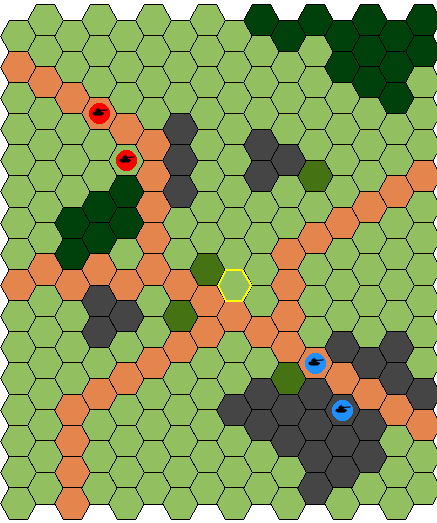

In [20]:
drawState(board, state)

The image also confirms the equality of the state.

# Agents

We create two agents: one for **red** and one for **blue**.

In [21]:
from agents import GreedyAgent

In [22]:
red = GreedyAgent(RED, 42)
blue = GreedyAgent(BLUE, 24)

In order to play with the agents, we need to use the `MatchManager`object. We will recycle the `state` and `board` above.

In [23]:
from agents import MatchManager

In [24]:
mm = MatchManager('', red, blue, board, state, 2)

Since the `MatchManager` outputs a lot of information, it is useful to enable the logs.

In [25]:
from utils.setup_logging import setup_logging
setup_logging()

With this object we can advance step by step in a match.

2021-06-10 15:58:56 agents.matchmanager INFO           2 SCENARIO: battleground16x16
2021-06-10 15:58:56 agents.matchmanager INFO           2 SEED:     2
2021-06-10 15:58:56 agents.matchmanager INFO           2 ==================================================
2021-06-10 15:58:56 agents.matchmanager INFO           2 Turn 0


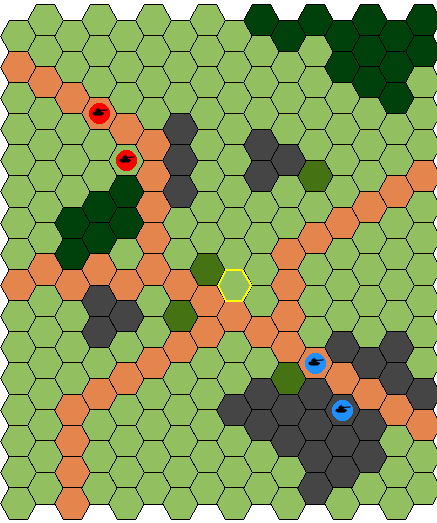

In [26]:
mm.nextStep()
drawState(mm.board, mm.state)

2021-06-10 15:58:56 agents.matchmanager INFO           2 red   action   : RED  : Tank1     : Moved to (8, 8) 


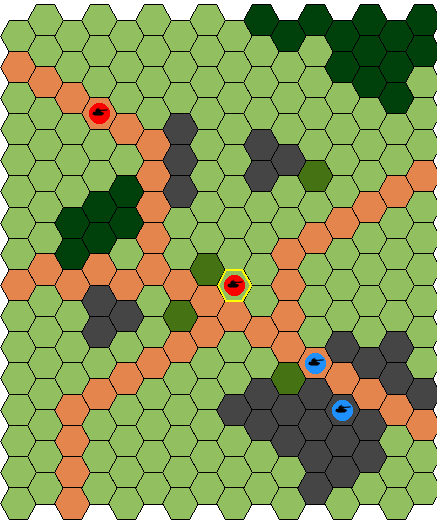

In [27]:
mm.nextStep()
drawState(mm.board, mm.state)

2021-06-10 15:58:56 agents.matchmanager INFO           2 blue  response : BLUE :           : Pass Team 


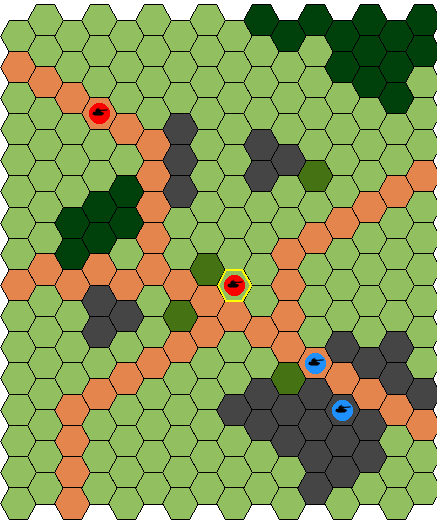

In [28]:
mm.nextStep()
drawState(mm.board, mm.state)

2021-06-10 15:58:56 agents.matchmanager INFO           2 red   action   : RED  : Tank2     : Moved to (8, 7) 


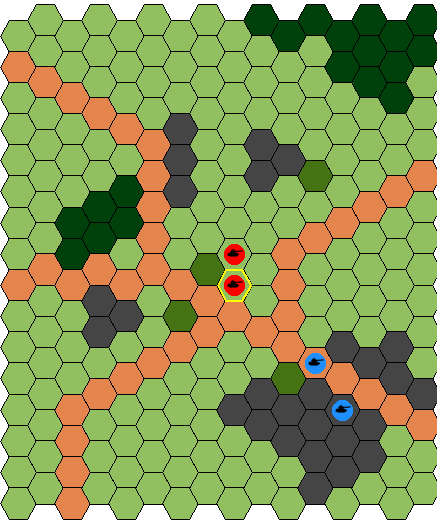

In [29]:
mm.nextStep()
drawState(mm.board, mm.state, 18)

Or let the match play itself.

In [30]:
mm.reset()
mm.play()

2021-06-10 15:58:56 agents.matchmanager INFO           2 SCENARIO: battleground16x16
2021-06-10 15:58:56 agents.matchmanager INFO           2 SEED:     2
2021-06-10 15:58:56 agents.matchmanager INFO           2 ==================================================
2021-06-10 15:58:56 agents.matchmanager INFO           2 Turn 0
2021-06-10 15:58:57 agents.matchmanager INFO           2 red   action   : RED  : Tank1     : Moved to (8, 8) 
2021-06-10 15:58:57 agents.matchmanager INFO           2 blue  response : BLUE :           : Pass Team 
2021-06-10 15:58:57 agents.matchmanager INFO           2 red   action   : RED  : Tank2     : Moved to (8, 7) 
2021-06-10 15:58:57 agents.matchmanager INFO           2 blue  response : BLUE :           : Pass Team 
2021-06-10 15:58:57 agents.matchmanager INFO           2 ==================================================
2021-06-10 15:58:57 agents.matchmanager INFO           2 Turn 1
2021-06-10 15:58:57 agents.matchmanager INFO           2 End game! Winner 